In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Example 1

$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$

With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [2]:
X_train = np.arange(0, 1., 0.1) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, 1., 0.01) + 1e-8
X_test = X_test.reshape(-1,1) 

In [3]:
class TrialSolution(tf.keras.models.Model):
  def __init__(self, conditions, n_i, n_h, n_o=1, activation='sigmoid'):
    super(TrialSolution, self).__init__()
    
    # Dimensions of the network
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    
    # Boundary conditions
    self.conditions = conditions
    
    # Shallow network
    self.hidden_layer = tf.keras.layers.Dense(units=self.n_h, activation=activation)
    self.output_layer = tf.keras.layers.Dense(units=self.n_o, activation='linear')
    
  def call(self, X):
    X = tf.convert_to_tensor(X)
    response = self.hidden_layer(X)
    response = self.output_layer(response)
    
    # Automatic conditions incorporation
    # It should be used to generate the *call* method instead of calculating it every damned time
    
    boundary_value = tf.constant(0., dtype='float64', shape=response.get_shape())
    
    for condition in self.conditions:
      vanishing = tf.constant(1., dtype='float64', shape=response.get_shape())
      if condition['type'] == 'dirichlet':
        temp_bc = tf.reshape(condition['function'](X), shape=boundary_value.shape)
        for vanisher in self.conditions:
          if vanisher['variable'] != condition['variable'] and vanisher['value'] != condition['value']:
            vanishing *= (X[:, vanisher['variable']]
                                    - tf.constant(vanisher['value'], dtype='float64', shape=boundary_value.shape))
        boundary_value += temp_bc * vanishing
        
        response *= (tf.reshape(X[:, condition['variable']], shape=boundary_value.shape) - tf.constant(condition['value'], dtype='float64', shape=boundary_value.shape))
      
    response += boundary_value
    return response

The trial solution for this case is $\Psi(x)=1 + x N(x)$.
The first function below is the function $A(x)=1$
and the second function is the function $B(x)=x$.

In [4]:
inits = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: tf.constant(1., dtype='float64', shape=(X.shape[0],1))}]

### Defining the trial solution with an apropiate network

In [5]:
ts = TrialSolution(inits, n_i=1, n_h=10, n_o=1)

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where $N(x)$ is the neural network and $L$ is some differential operator.

In [6]:
def diff_loss(network, inputs):
  # Compute the gradients
  with tf.GradientTape() as tape:
    inputs = tf.convert_to_tensor(inputs)
    tape.watch(inputs)
    response = network(inputs)
  grads = tape.gradient(response, inputs)
  X = inputs
  
  # Compute the loss
  loss = tf.square(grads + tf.multiply(X + (1 + 3*X**2)/(1+X+X**3), response)
          - X**3 -2*X - X**2*(1 + 3*X**2)/(1+X+X**3))
  return loss

In [7]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
train_loss = tf.keras.metrics.Mean('train')

In [8]:
@tf.function
def train_step(X):
  # Online learning
  for i in X:
    with tf.GradientTape() as tape:
      loss = diff_loss(ts, tf.reshape(i, shape=(1,1)))
    gradients = tape.gradient(loss, ts.trainable_variables)
    optimizer.apply_gradients(zip(gradients, ts.trainable_variables))
  
  train_loss(diff_loss(ts, X))

Let's check if everything is fine.

In [9]:
ts(tf.convert_to_tensor(X_train))

<tf.Tensor: id=93, shape=(10, 1), dtype=float64, numpy=
array([[1.        ],
       [1.01302321],
       [1.02900389],
       [1.04792586],
       [1.06976231],
       [1.09447609],
       [1.12202005],
       [1.1523375 ],
       [1.18536272],
       [1.2210216 ]])>

### Training

In [10]:
EPOCHS = 1000000
for epoch in range(EPOCHS):
  train_step(X_train)
  if (epoch+1) % 10000 == 0:
    print(train_loss.result().numpy())
#     pred = ts.call(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
#     plt.plot(X_train, pred)
#     plt.plot(X_train, np.exp(-0.5*X_train**2)/(1+X_train+X_train**3) + X_train**2)
#     plt.show()

0.008523327
0.0044707465
0.003071375
0.002359886
0.0019279623
0.0016372572
0.0014280798
0.0012702614
0.0011470743
0.0010483711
0.00096860086
0.00090212567
0.00084663206
0.00079846167
0.00075311045
0.00070825557
0.0006673115
0.0006309168


KeyboardInterrupt: 

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

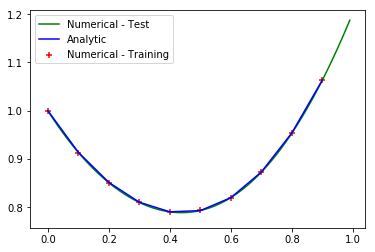

In [11]:
pred_train = ts.call(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
pred_test = ts(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
plt.scatter(X_train, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test, pred_test, c='g', label='Numerical - Test')
plt.plot(X_train, np.exp(-0.5*X_train**2)/(1+X_train+X_train**3) + X_train**2, c='b', label='Analytic')
plt.legend()
plt.show()

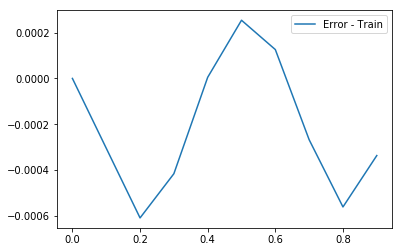

In [12]:
plt.plot(X_train, pred_train - np.exp(-0.5*X_train**2)/(1+X_train+X_train**3) - X_train**2, label='Error - Train')
plt.legend()
plt.show()

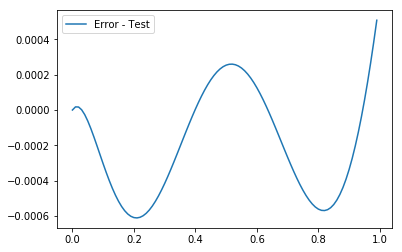

In [13]:
plt.plot(X_test, pred_test - np.exp(-0.5*X_test**2)/(1+X_test+X_test**3) - X_test**2, label='Error - Test')
plt.legend()
plt.show()

In [14]:
diff_loss(ts, X_test).numpy().mean()

1.9359543225058756e-05

In [15]:
(pred_test - np.exp(-0.5*X_test**2)/(1+X_test+X_test**3) - X_test**2).mean()

-0.000191440378557814

In [16]:
(pred_train - np.exp(-0.5*X_train**2)/(1+X_train+X_train**3) - X_train**2).mean()

-0.0002107967618815762